In [1]:
import os
os.chdir("../")

In [4]:
# !pip install ultralytics pytesseract

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from ultralytics import YOLO
import os
import pytesseract

# Load the performance data
df_performance = pd.read_csv('data/performance_data.csv')
df_performance = df_performance.head(1)  # For demonstration purposes

# Create an empty dictionary to store the results
results = {}

# Iterate through each row in the dataframe
for index, row in df_performance.iterrows():
    game_id = row['game_id']
    image_path = f'data/Assets/{game_id}/_preview.png'

    # Check if the image file exists
    if os.path.exists(image_path):
        # Load the image using Pillow
        img = Image.open(image_path)

        # Object Identification
        model = YOLO('yolov8n.pt')  # Load a YOLOv8 model (you might need to download it first)
        results_yolo = model(image_path)
        class_names = [model.names[int(result.boxes.cls[0])] for result in results_yolo]
        results[game_id] = {'objects': class_names}

        # Color Identification
        img_rgb = img.convert('RGB')
        img_array = np.array(img_rgb).reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, random_state=0).fit(img_array)
        dominant_colors = kmeans.cluster_centers_.astype(int)
        results[game_id]['colors'] = dominant_colors.tolist()

        # Position Extraction
        positions = []
        for result in results_yolo:
            x1, y1, x2, y2 = result.boxes.xyxy[0]
            positions.append([x1 / img.width, y1 / img.height, x2 / img.width, y2 / img.height])
        results[game_id]['positions'] = positions

        # Character Recognition
        text = pytesseract.image_to_string(img)
        results[game_id]['text'] = text

# Create a new dataframe from the results dictionary
df_features = pd.DataFrame.from_dict(results, orient='index')

# Merge the new dataframe with the original dataframe on the `game_id` column
merged_df = df_performance.merge(df_features, left_on='game_id', right_index=True, how='left')

# Display the first 5 rows of the merged dataframe
print(merged_df.head().to_markdown(index=False, numalign="left", stralign="left"))


image 1/1 /home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/bfbf7a2b7ac635e67877b1ab87fd6629/_preview.png: 640x448 2 kites, 234.8ms
Speed: 4.0ms preprocess, 234.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


| game_id                          | preview_link                                                                                                                                            | ER       | CTR       | objects   | colors                                                                        | positions                                                          | text                                 |
|:---------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------|:---------|:----------|:----------|:------------------------------------------------------------------------------|:-------------------------------------------------------------------|:-------------------------------------|
| bfbf7a2b7ac635e67877b1ab87fd6629 | https://s3.us-east-1.amazonaws.com/a.futureadlabs.com-us-east-1-backup/us-east-1/games/bfbf7a2b7ac635e67877b1ab87fd6629/b7a604b3b08f086

In [3]:
from ultralytics import YOLO
import pytesseract
from PIL import Image
import os

def extract_text_with_positions(image_path):
    """
    Extracts text from an image and returns a dictionary mapping the text to its position (bounding box).

    Args:
        image_path: The path to the image file.

    Returns:
        A dictionary where keys are text strings and values are lists of bounding box coordinates
        in the format [x1, y1, x2, y2] (normalized to image width and height).

    Raises:
        FileNotFoundError: If the image file does not exist.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Load image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Text Detection and OCR (Optical Character Recognition)
    model = YOLO('yolov8n.pt') 
    results_yolo = model(image_path)  
    
    text_positions = {}
    for result in results_yolo:
        if result.boxes.cls[0] == 3:  # Filter for 'text' class in YOLOv8 (adjust if needed)
            x1, y1, x2, y2 = result.boxes.xyxy[0]  # Extract coordinates
            cropped_image = img.crop((x1, y1, x2, y2))
            text = pytesseract.image_to_string(cropped_image)  # Perform OCR on cropped region
            if text:
                normalized_coords = [x1 / img_width, y1 / img_height, x2 / img_width, y2 / img_height]
                text_positions[text.strip()] = normalized_coords  # Add to dictionary

    return text_positions


In [9]:
image_path = "/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png"

In [4]:
text_positions = extract_text_with_positions(image_path)
for text, position in text_positions.items():
    print(f"Text: '{text}', Position: {position}")


100%|██████████| 6.25M/6.25M [00:00<00:00, 324MB/s]



image 1/1 /home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png: 544x640 1 kite, 289.3ms
Speed: 4.3ms preprocess, 289.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


In [5]:
print(text_positions)

{}


In [7]:
import pytesseract
from pytesseract import Output
from PIL import Image

def extract_text_with_positions(image_path):
    # Load the image using Pillow
    img = Image.open(image_path)

    # Use pytesseract to get the bounding boxes
    data = pytesseract.image_to_data(img, output_type=Output.DICT)

    # Initialize the result dictionary
    text_positions = {}

    # Iterate through the data to extract text and their positions
    n_boxes = len(data['level'])
    for i in range(n_boxes):
        if data['text'][i].strip():  # Check if the text is not empty
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            # Store the position as a tuple (left, top, right, bottom)
            text_positions[text] = (x, y, x + w, y + h)

    return text_positions


In [ ]:

# Example usage
result = extract_text_with_positions(image_path)
print(result)


In [12]:
header_image_path = "/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg"
result = extract_text_with_positions(header_image_path)
print(result)

{'Ovexus': (50, 27, 245, 60), 'L/CERTIFIED': (50, 77, 161, 90), 'BY': (174, 77, 198, 90), 'LEXUS': (211, 77, 283, 90)}


In [13]:
thumbnail_image_path = "/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/thumbnail.jpg"
result = extract_text_with_positions(thumbnail_image_path)
print(result)

{}


In [15]:
engagement_instruction = "/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png"
result = extract_text_with_positions(engagement_instruction)
print(result)

{'TAP': (0, 1, 64, 28), 'THE': (75, 1, 140, 28), 'SCREEN': (152, 0, 293, 29), 'to': (0, 40, 21, 58), 'find': (27, 36, 65, 58), 'the': (73, 36, 106, 58), 'nearest': (114, 40, 192, 58), 'Lexus': (200, 36, 261, 58), 'dealership': (268, 36, 380, 63)}


#### Compose a frame that is not aligned properly for testing

In [10]:
import os
os.chdir("../")
from src.image_composition import compose_ad_frame


In [12]:
import sys
from dotenv import load_dotenv

load_dotenv()
PROJECT_PATH = os.environ.get('PROJECT_PATH')

# Add the project root path to sys.path
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)

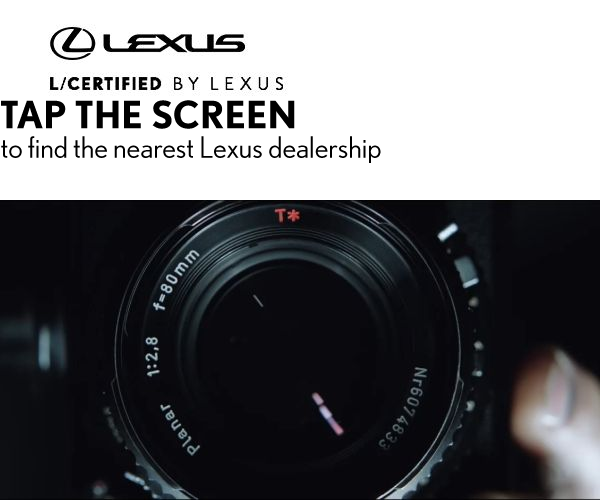

In [19]:

game_id = "0a22f881b77f00220f2034c21a18b854"
assets_path = os.path.join(PROJECT_PATH, 'data', 'Assets', game_id)

# Example usage
# assets_path = '/path/to/assets'
elements = [
    {'image_path': f'{assets_path}/header.jpg', 'position': (0, 0), 'has_background': True},
    {'image_path': f'{assets_path}/engagement_instruction_1.png', 'position': (1, 100), 'has_background': False},
    {'image_path': f'{assets_path}/thumbnail.jpg', 'position': (0, 200), 'has_background': True}
]

composed_frame = compose_ad_frame(600, 500, elements, output_path="/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/composed_img.png")
composed_frame.show()  # Or save using composed_frame.save('composed_frame.jpg')
# print(composed_frame)


In [20]:
composed_img = "/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/composed_img.png"
result = extract_text_with_positions(composed_img)
print(result)

{'Ovexus': (50, 27, 245, 60), 'L/CERTIFIED': (50, 77, 161, 90), 'BY': (174, 77, 198, 90), 'LEXUS': (211, 77, 283, 90), 'TAP': (1, 101, 65, 128), 'THE': (76, 101, 141, 128), 'SCREEN': (153, 100, 294, 129), 'to': (1, 140, 22, 158), 'find': (28, 136, 66, 158), 'the': (74, 136, 107, 158), 'nearest': (115, 140, 193, 158), 'Lexus': (201, 136, 262, 158), 'dealership': (269, 136, 381, 163)}


#### Using OpenCV and pytesseract with YOLO

In [3]:
import cv2
import pytesseract
from pytesseract import Output

# Load the image
# image_path = '.png'
image = cv2.imread(engagement_instruction)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load YOLO model (replace with the path to your YOLO model files)
# You need to download YOLO weights and config files for this to work
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Prepare the image for object detection
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Extract bounding boxes from YOLO output
height, width, channels = image.shape
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Adjust confidence threshold as needed
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append((x, y, w, h))

# Draw bounding boxes and perform OCR on each box
for (x, y, w, h) in boxes:
    roi = gray[y:y+h, x:x+w]
    text = pytesseract.image_to_string(roi, config='--psm 6')  # Adjust PSM mode as needed
    print(f"Detected text: {text}")
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Show the image with bounding boxes and detected text
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


NameError: name 'engagement_instruction' is not defined

In [5]:
import re
import cv2
import pytesseract
from pytesseract import Output

img = cv2.imread(composed_img)
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:
    if re.match(date_pattern, d['text'][i]):
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
